In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [31]:
TICKSIZE = 15
TITLESIZE = 25

# Damage per Round - Einleitung

Zwei Punkte, die den Schaden pro Runde beeinflussen:
1. Trefferwahrscheinlichkeit
2. Waffenschaden (Damage Die + Bonus)
3. (Crits)

Kritische treffer sind eigentlich kein eigener Punkt, vielmehr sind Crits genauso eine Kombination aus Damage und Wahrscheinlichkeit.

## Trefferwahrscheinlichkeit?

* Geworfen wird ein d20 - jede Zahl steht für 5% Wahrscheinlichkeit
* Das Würfelergebnis muss über einem bestimmten Wert liegen (AC)
* Trefferwahrscheinlichkeit = Wahrscheinlichkeit über einem gewissen Wert zu liegen

$Trefferwahrscheinlichkeit = 1 - \frac{(Benötigtes Ergebnis) -1}{20}$

### Beispiel:

Die Wahrscheinlichkeit eine AC 10 ohne Modifier zu treffen ist: 55%

Denn zählen wir die Anzahl der positiven Ausgänge: 10 (Meets it Beats it), 11, 12, 13 ... 20 kommen wir auf 11.

D.h. in 11 von 20 Fällen treffen wir, oder: $\frac{11}{20}=0,55=55\%$

In [32]:
toHit_prob = pd.DataFrame(index=list(range(2,21)))
toHit_prob.index.name = "Benötigtes Ergebnis"
toHit_prob["Trefferwahrscheinlichkeit"] = 1-(toHit_prob.index-1)/20
toHit_prob.transpose()

Benötigtes Ergebnis,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Trefferwahrscheinlichkeit,0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.55,0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,0.05


## Waffenschaden

Der reine Schaden, der diese Waffe macht. In DnD haben wir 6 unterschiedliche Schadenswürfel:

* d4, d6, d8, d10, d12, 2d6

### Durchschnittlicher Schaden

Das durchschnittliche Würfelergebnis eines d4 ist 2,5.

$\hat{x} = \frac{1+2+3+4}{4} = \frac{10}{4} = 2,5$

Gleiches gilt für jeden Würfel.
* d6 = 3,5
* d8 = 4,5
* d10 = 5,5
* d12 = 6,5
* 2d6 = 7

$ \hat{Würfelergebnis} = Würfelanzahl*\frac{Max.Würfelergebnis+1}{2}$


## Zu erwartender Schaden

Der durchschnittliche Schaden einer Waffe wäre erreicht, wenn man bei unendlich vielen Versuchen zu 100% trifft.

Da das nicht der Fall ist, muss der durchschnittliche Schaden mit der Trefferwahrscheinlichkeit modifiziert werden, um den zu erwartenden Schaden zu ergeben.

$\mu= Trefferwahrscheinlichkeit*\hat{Würfelergebnis}$

### Beispiel

Man kann nun sagen, dass wenn ich mit einer Waffe:
* die durchschnittlich 3,5 Schaden macht (d6)
* in 55% der Fälle meinen Gegner treffe (10 und darüber trifft)
* dann kann ich erwarten, mit jedem Angriff 1,925 Punkte Schaden mache.

$3,5*0,55 = 1,925$



## Was ist mit den Crits?

Mit kritischen Treffern verhält es sich genau gleich und die Mechanik wird in den zu erwartenden Schaden miteingerechnet.

* Die Chance auf einen Crit ist (normalerweise) 5% (20 auf einem d20)
* Die Würfelanzahl wird verdoppelt (1d6 --> 2d6)

### Beispiel
* Kritischer Schaden: 1d6 --> 2d6 = 3,5 --> 7
* Crit-Wahrscheinlichkeit = 0,05

$7*0,05=0,35$

* Diese 0,35 werden nun zu dem "normalen" erwartenden Schaden addiert (s.o. 1,925).

$1,925+0,35=2,275$

* Somit ist der tatsächlich zu erwartende Schaden 2,275

In [33]:
class Dice:
    def __init__(self, minRoll, maxRoll):
        self.name = "d{}".format(maxRoll)
        self.minRoll = minRoll
        self.maxRoll = maxRoll
        self.dice = np.arange(minRoll,maxRoll+1)
    def calcDiceMean(self):
        diceMean = self.dice.mean()
        return diceMean
    

dice_dictionary = {
    "d2":Dice(1,2),
    "d4":Dice(1,4),
    "d6":Dice(1,6),
    "d8":Dice(1,8),
    "d10":Dice(1,10),
    "d12":Dice(1,12),
    "d20":Dice(1,20),
    "d100":Dice(1,100),
}

In [34]:
# def calc_chance_toHit(toHitBonus, monsterAC, critOn=20, checkAdvantage=False):

#     toHitAC = monsterAC - toHitBonus
#     if checkAdvantage:
#         chance2Hit = 1 - ((toHitAC-1)/20)**2
#         chance2Crit = 1-((critOn-1)/20)**2
#     else:
#         chance2Hit = 1 - (toHitAC-1)/20
#         chance2Crit = 1-((critOn-1)/20) 
#     return chance2Hit, chance2Crit

# def calc_DiceDamage(damageDice, damageDice_amount, critMultiplier):
#     weaponDiceDamage = damageDice.calcDiceMean()*damageDice_amount
#     weaponCritDamage = weaponDiceDamage*critMultiplier
#     return weaponDiceDamage, weaponCritDamage

# def apply_damageBonus(weaponDiceDamage, weaponCritDamage, damageBonus):
#     averageDamage = weaponDiceDamage+damageBonus
#     averageCritDamage = weaponCritDamage+damageBonus
#     return averageDamage, averageCritDamage

# def calc_expectedDamage(averageDamage, averageCritDamage, chanceToHit, critChance):
#     expectedDamage = averageDamage*chanceToHit+averageCritDamage*critChance
#     return expectedDamage

# def damageCalculator(hero, monsterAC, damageDice, damageDice_amount, damageBonus, checkAdvantage=False, ):
#     chance2Hit, chance2Crit = calc_chance_toHit(hero.toHitBonus, monsterAC, hero.critOn, checkAdvantage)
#     weaponDiceDamage, weaponCritDamage = calc_DiceDamage(damageDice, damageDice_amount, hero.critMultiplier)
#     averageDamage, averageCritDamage = apply_damageBonus(weaponDiceDamage, weaponCritDamage, damageBonus)
#     expectedDamage = calc_expectedDamage(averageDamage, averageCritDamage, chance2Hit, chance2Crit)
#     return expectedDamage, averageDamage, averageCritDamage, chance2Hit, chance2Crit, weaponDiceDamage, weaponCritDamage

# def calc_growth(old_value, new_value):
#     return (new_value-old_value)/old_value

In [35]:
class Hero:
    def __init__(self, name, toHitBonus, damageBonus, critOn=20, critMultiplier=2):
        # toHitBonus: z.B. Archery Fighting Style
        # critOn: change if e.g. Fighter/Champion
        self.name = name
        self.toHitBonus = toHitBonus
        self.damageBonus = damageBonus
        self.critOn = critOn
        self.critMultiplier = critMultiplier

        self.damageSources = {}

    def addDamageSource(self, source):
        self.damageSources[self.damageSources.name] = source
    
    def damageCalculator(self, monsterAC, damageDice, damageDice_amount, checkAdvantage=False):
        
        # -------------- Calc Chance to Hit
        toHitAC = monsterAC - self.toHitBonus
        if checkAdvantage:
            chance2Hit = 1 - ((toHitAC-1)/20)**2
            chance2Crit = 1-((self.critOn-1)/20)**2
        else:
            chance2Hit = 1 - (toHitAC-1)/20
            chance2Crit = 1-((self.critOn-1)/20)
        
        # -------------- Calc Dice Damage
        diceBaseDamage = damageDice.calcDiceMean()*damageDice_amount
        diceCritDamage = diceBaseDamage*self.critMultiplier

        # -------------- Calc avg Damage (apply Damage Bonus)
        averageDamage = diceBaseDamage+self.damageBonus
        averageCritDamage = diceCritDamage+self.damageBonus

        # ------------- Calc expected Damage (avg. Damage * Chance to Hit)
        expectedDamage = averageDamage*chance2Hit+averageCritDamage*chance2Crit

        return[expectedDamage, averageDamage, averageCritDamage, chance2Hit, chance2Crit, diceBaseDamage, diceCritDamage]
  
    
    def show_hero_stats(self, monsterAC, damageDice, damageDice_amount):
        values = self.damageCalculator(monsterAC, damageDice, damageDice_amount)
        print(f"Helden Name: {self.name}")
        print(f"ToHit-Bonus: {self.toHitBonus:+}")
        print(f"Trefferwahrscheinlichkeit: {values[3]}, bei einer Monster AC von: {monsterAC}")
        print(f"Waffenschaden: {damageDice_amount}{damageDice.name}{self.damageBonus:+}, Durchschnittlicher Schaden: {values[1]:.2f} (Crit: {values[2]:.2f})")
        print(f"Zu erwartender Schaden: {values[0]:.2f} pro Attacke")



In [36]:
tester_toni = Hero("Toni Tester", toHitBonus=5, damageBonus=2)

tester_toni.show_hero_stats(
    monsterAC=10,
    damageDice=dice_dictionary["d8"],
    damageDice_amount=1
)

Helden Name: Toni Tester
ToHit-Bonus: +5
Trefferwahrscheinlichkeit: 0.8, bei einer Monster AC von: 10
Waffenschaden: 1d8+2, Durchschnittlicher Schaden: 6.50 (Crit: 11.00)
Zu erwartender Schaden: 5.75 pro Attacke


# Welchen Unterschied macht die Wahl der Waffe?

In [37]:
weapon_dictionary = {
    "1d4":(1, dice_dictionary["d4"]),
    "1d6":(1, dice_dictionary["d6"]),
    "1d8":(1, dice_dictionary["d8"]),
    "1d10":(1, dice_dictionary["d10"]),
    "1d12":(1, dice_dictionary["d12"]),
    "2d6":(2, dice_dictionary["d6"]),
}
list_of_weapons = list(weapon_dictionary.keys())
print("Typische Damage Dice:", ", ".join(list_of_weapons))

Typische Damage Dice: 1d4, 1d6, 1d8, 1d10, 1d12, 2d6


In [38]:
def calculate_dmg_parts(value_array):
    weapon_base_damage = value_array[5]*value_array[3] # weaponDiceDamage * chance2Hit
    weapon_crit_damage = value_array[6]*value_array[4] # weaponCritDamage * chance2Crit
    modifier_bonus = (value_array[1]-value_array[5])*value_array[3]+(value_array[2]-value_array[6])*value_array[4] # (averageDamage - weaponDiceDamage) * chance2Hit + averageCritDamage - weaponCritDamage * chance2Crit
    return [weapon_base_damage, weapon_crit_damage, modifier_bonus]

def modify_data_4_plot(data_dictionary):
    weapon_base_damages = []
    weapon_crit_damages = []
    modifier_bonus = []

    for value in data_dictionary:
        plot_data = calculate_dmg_parts(data_dictionary[value])
        weapon_base_damages.append(plot_data[0])
        weapon_crit_damages.append(plot_data[1])
        modifier_bonus.append(plot_data[2])
    
    plot_dict = {
        "Weapon Base Damage":weapon_base_damages,
        "Weapon Crit Damage":weapon_crit_damages,
        "Modifier Bonus":modifier_bonus,
    }

    return plot_dict

def draw_stacked_bar_plot(plot_dict, labels, title):
    fig, ax = plt.subplots(figsize=(12,10), layout="constrained")
    bottom = np.zeros(len(labels))
    width = 0.5

    for dmgType, dmgValue in plot_dict.items():
        p = ax.bar(x=labels, height=dmgValue, width=width, label=dmgType, bottom=bottom)
        ax.bar_label(p, label_type="center", fontsize=TICKSIZE-1)
        bottom += dmgValue
    ax.bar_label(p, padding=3, fontsize=TICKSIZE)
    ax.set_title(f"{title}", fontsize=TITLESIZE)
    ax.legend(loc="best", fontsize=TICKSIZE)

    return fig, ax

def stacked_bar_plot_from_dict(data_dictionary, title):
    plot_dict = modify_data_4_plot(data_dictionary)
    fig, ax = draw_stacked_bar_plot(plot_dict, labels=list(data_dictionary.keys()), title=title)
    return fig, ax, plot_dict

def calc_growth(old_value, new_value):
    return (new_value-old_value)/old_value

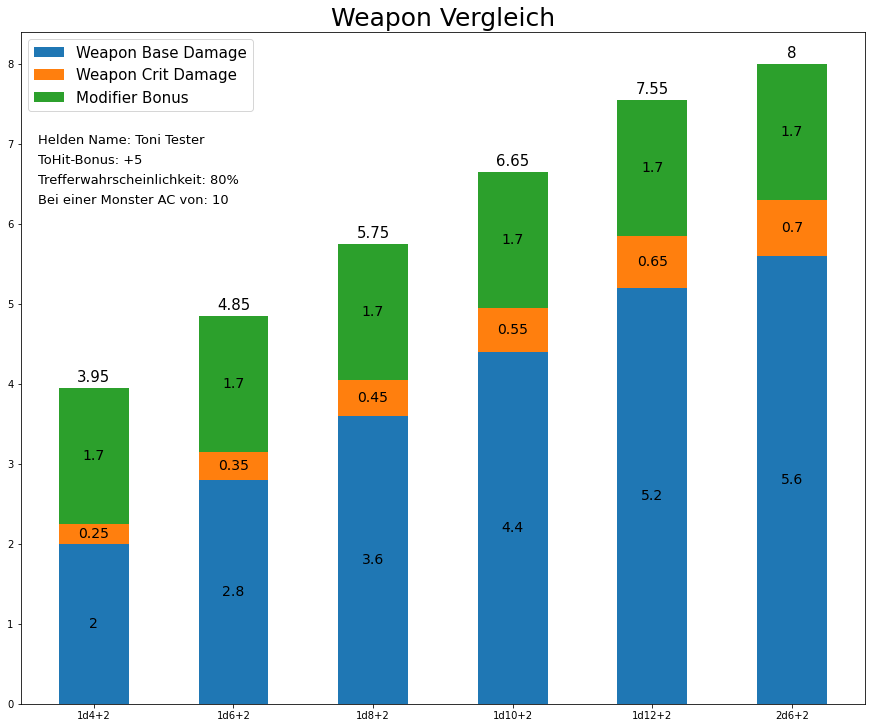

In [39]:
tester_toni.damageBonus = 2
weapon_damage_dict_base = {}
label_list = []

monsterAC = 10
textsize = 13


for weapon in weapon_dictionary:
    weapon_damage_dict_base[weapon] = tester_toni.damageCalculator(monsterAC, weapon_dictionary[weapon][1], weapon_dictionary[weapon][0])
    label_list.append(f"{weapon_dictionary[weapon][0]}{weapon_dictionary[weapon][1].name}{tester_toni.damageBonus:+}")
weapon_damage_dict_base
fig, ax, pDict = stacked_bar_plot_from_dict(weapon_damage_dict_base, "Weapon Vergleich")
ax.text(-0.4,7.0,s=f"Helden Name: {tester_toni.name}", fontdict={"size":textsize})
ax.text(-0.4,6.75,s=f"ToHit-Bonus: {tester_toni.toHitBonus:+}", fontdict={"size":textsize})
ax.text(-0.4,6.5,s=f"Trefferwahrscheinlichkeit: {weapon_damage_dict_base['1d4'][3]:.0%}", fontdict={"size":textsize})
ax.text(-0.4,6.25,s=f"Bei einer Monster AC von: {monsterAC}", fontdict={"size":textsize})
ax.set_xticks([0, 1, 2,3,4,5])
ax.set_xticklabels(label_list)

plt.show()

# Was ist besser? Ein +2 Schwert, oder Flame Tongue Sword

Zum Vergleich stehen:
* Ein Flame Tongue Longsword mit zusätzlichen 2d6 fire damage
* Ein +2 Longsword

## Punkte zu bedenken
* Beide werden vom Spiel als "rare" eingestuft.
* 2d6 fire Damage sind im Schnitt 7 Punkte Damage
* Das +2 Schwert hat "nur" +2 - aber auch ein +2 auf to Hit
    * Kann das +2 to Hit für den Unterschied im Damage ausmachen?

In [40]:
class Dice:
    def __init__(self, minRoll, maxRoll):
        self.name = "d{}".format(maxRoll)
        self.minRoll = minRoll
        self.maxRoll = maxRoll
        self.dice = np.arange(minRoll,maxRoll+1)
        self.diceMean = self.dice.mean()
   

In [41]:
class DamageSource:
    def __init__(self, name, staticBonus=None, damageDice=None, diceAmount=None):
        self.name = name
        self.is_static = False
        if staticBonus:
            self.baseDamage = staticBonus
            self.is_static = True
        else:
            self.baseDamage = damageDice.diceMean*diceAmount

In [42]:
class Hero:
    def __init__(self, name, toHitBonus, critOn=20, critMultiplier=2):
        # toHitBonus: z.B. Archery Fighting Style
        # critOn: change if e.g. Fighter/Champion
        self.name = name
        self.toHitBonus = toHitBonus
        self.critOn = critOn
        self.critMultiplier = critMultiplier

        self.damageSources = {} # stores different types of damage

    def calcCritDamage(self):
        for s in self.damageSources:
            if self.damageSources[s].is_static:                
                self.damageSources[s].critDamage = self.damageSources[s].baseDamage
            else:
                self.damageSources[s].critDamage = self.damageSources[s].baseDamage*self.critMultiplier
               
    def addDamageSource(self, source):
        self.damageSources[source.name] = source
        self.calcCritDamage()
    
    def calcToHitChance(self, monsterAC, checkAdvantage=False):
        toHitAC = monsterAC - self.toHitBonus
        if toHitAC < 2:
            toHitAC = 2
        if toHitAC > 19:
            toHitAC = 21
        if checkAdvantage:
            self.chance2Hit = 1 - ((toHitAC-1)/20)**2
            self.chance2Crit = 1-((self.critOn-1)/20)**2
        else:
            self.chance2Hit = 1 - (toHitAC-1)/20
            self.chance2Crit = 1-((self.critOn-1)/20)
            
    def damageCalculator(self):
        self.base_damage = {} # base Damage of each damage Source
        self.crit_damage = {} # crit Damage of each damage Source
        self.expected_damage = {} # expected Damage of each damage Source
        
        for s in self.damageSources:
            self.expected_damage[s] = self.damageSources[s].baseDamage*self.chance2Hit + self.damageSources[s].critDamage*self.chance2Crit
            self.base_damage[s] = self.damageSources[s].baseDamage
            self.crit_damage[s] = self.damageSources[s].critDamage
        
        self.heroValues = { # sums up damage types
            "Expected Damage":sum(self.expected_damage.values()),
            "Base Damage":sum(self.base_damage.values()),
            "Crit Damage":sum(self.crit_damage.values()),
            "Chance to Hit":self.chance2Hit
        }          
    
    def show_hero_stats(self):
        print(f"Helden Name: {self.name}")
        print(f"ToHit-Bonus: {self.toHitBonus:+}")
        print(f"Trefferwahrscheinlichkeit: {self.chance2Hit}")
        print(f"Zu erwartender Schaden: {sum(self.expected_damage.values()):.2f}")

In [50]:
plus2_toni = Hero("Toni Plus2", 7)
plus2_toni.addDamageSource(DamageSource("Longsword", damageDice=Dice(1,8), diceAmount=1))
plus2_toni.addDamageSource(DamageSource("Ability Modifier", staticBonus=3))
plus2_toni.addDamageSource(DamageSource("Sword Dmg Bonus", staticBonus=2))
plus2_toni.calcToHitChance(monsterAC=10)
plus2_toni.damageCalculator()
plus2_toni.show_hero_stats()
print("--------------------")
flameTongue_toni = Hero("Toni Flame Tongue", 5)
flameTongue_toni.addDamageSource(DamageSource("Longsword", damageDice=Dice(1,8), diceAmount=1))
flameTongue_toni.addDamageSource(DamageSource("Ability Modifier", staticBonus=3))
flameTongue_toni.addDamageSource(DamageSource("Flame Tongue", damageDice=Dice(1,6), diceAmount=2))
flameTongue_toni.calcToHitChance(monsterAC=10)
flameTongue_toni.damageCalculator()
flameTongue_toni.show_hero_stats()

Helden Name: Toni Plus2
ToHit-Bonus: +7
Trefferwahrscheinlichkeit: 0.9
Zu erwartender Schaden: 9.25
--------------------
Helden Name: Toni Flame Tongue
ToHit-Bonus: +5
Trefferwahrscheinlichkeit: 0.8
Zu erwartender Schaden: 12.90


## Zwischenfazit

Man sieht also einen deutlichen Unterschied von 3,65 Punkten bei einer Monster AC von 10

Aber wir haben noch nicht die erhöhte Trefferwahrscheinlichkeit überprüft.

Existiert ein Punkt, bei dem sich der Bonus auf toHit auszahlt?

## Zu erwartender Schaden nach AC

In [44]:
magicItem_DF = pd.DataFrame(index=list(range(1,29)) ,columns=["Flame Tongue", "+2 Sword"])
magicItem_DF.index.name = "Monster AC"
for ac in magicItem_DF.index:
    plus2_toni.calcToHitChance(monsterAC=ac)
    plus2_toni.damageCalculator()
    flameTongue_toni.calcToHitChance(monsterAC=ac)
    flameTongue_toni.damageCalculator()

    magicItem_DF.loc[ac] = [sum(flameTongue_toni.expected_damage.values()), sum(plus2_toni.expected_damage.values())]
magicItem_DF["Unterschied"] = magicItem_DF["Flame Tongue"]-magicItem_DF["+2 Sword"]

magicItem_DF.transpose()

Monster AC,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
Flame Tongue,15.075,15.075,15.075,15.075,15.075,15.075,15.075,14.35,13.625,12.9,...,6.375,5.65,4.925,4.2,3.475,2.75,1.3,1.3,1.3,1.3
+2 Sword,9.725,9.725,9.725,9.725,9.725,9.725,9.725,9.725,9.725,9.25,...,4.975,4.5,4.025,3.55,3.075,2.6,2.125,1.65,0.7,0.7
Unterschied,5.35,5.35,5.35,5.35,5.35,5.35,5.35,4.625,3.9,3.65,...,1.4,1.15,0.9,0.65,0.4,0.15,-0.825,-0.35,0.6,0.6


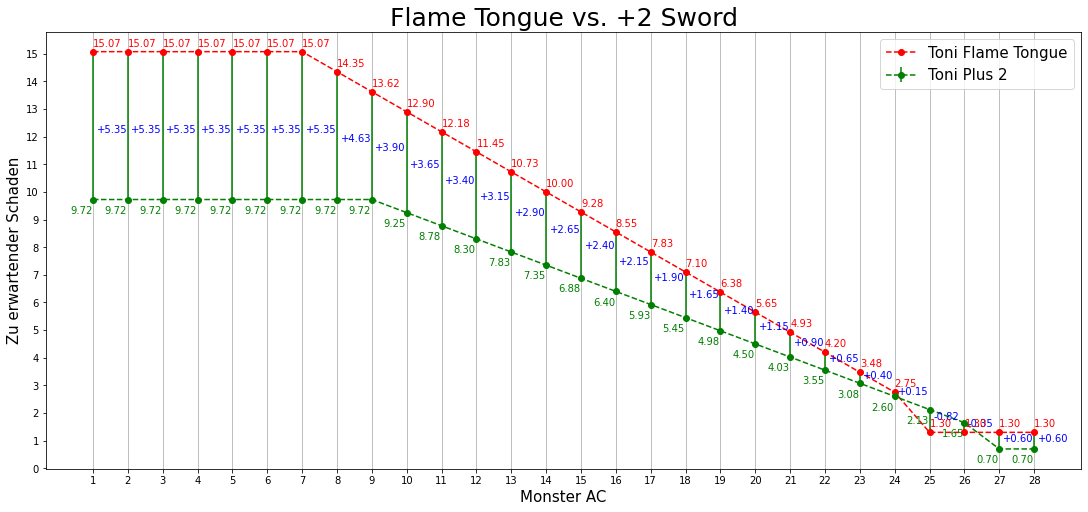

In [45]:
X = magicItem_DF.index
TICKSIZE = 15
TITLESIZE = 25

yerror = list(magicItem_DF["Flame Tongue"]-magicItem_DF["+2 Sword"])
fig, ax = plt.subplots(figsize=(15,7), layout="constrained")
ax.errorbar(X, y=magicItem_DF["+2 Sword"], yerr=[[0]*28,yerror], fmt="--go", label= "Toni Plus 2")
ax.plot(X, magicItem_DF["Flame Tongue"], "--ro", label= "Toni Flame Tongue")
# ax.plot(X, magicItem_DF["+2 Sword"], "--go", label= "+2 Sword")
for x,diff,plus2,ft in zip(X, magicItem_DF["Unterschied"], magicItem_DF["+2 Sword"], magicItem_DF["Flame Tongue"]):
    ax.annotate(text=f"{diff:+.2f}", xy=(x+0.1, plus2+diff*0.45)).set_color("b")
    ax.annotate(text=f"{plus2:.2f}", xy=(x-0.66, plus2-0.5)).set_color("g")
    ax.annotate(text=f"{ft:.2f}", xy=(x, ft+0.2)).set_color("r")
ax.grid(True, axis="x")
ax.set_xticks(ticks=X)
ax.set_yticks(ticks=range(16))
ax.set_xlabel("Monster AC", fontsize=TICKSIZE)
ax.set_ylabel("Zu erwartender Schaden", fontsize=TICKSIZE)
ax.set_title("Flame Tongue vs. +2 Sword", fontsize=TITLESIZE)
ax.legend(loc="best", fontsize=TICKSIZE)

plt.show()

# Advantage Disadvantage Auswertung

In [46]:
advDF = pd.DataFrame(index=list(range(2,21)))
advDF.index.name = "Benötigtes Ergebnis"

advDF["Trefferwahrscheinlichkeit"] = (1 - (advDF.index-1)/20)
advDF["mit Advantage"] = (1 - ((advDF.index-1)/20)**2)
advDF["mit Disadvantage"] = ((20-advDF.index+1)/20)**2

advDF["Unterschied zu Base"] = advDF["mit Advantage"] - advDF["Trefferwahrscheinlichkeit"]
# advDF["Dadv Unterschied zu Base"] = advDF["mit Disadvantage"] - advDF["Trefferwahrscheinlichkeit"]
advDF["Umrechnung statischer Bonus"] = advDF['Unterschied zu Base']*20 #(*100/5)
advDF

,Trefferwahrscheinlichkeit,mit Advantage,mit Disadvantage,Unterschied zu Base,Umrechnung statischer Bonus
Benötigtes Ergebnis,,,,,
2,0.95,0.9975,0.9025,0.0475,0.95
3,0.90,0.9900,0.8100,0.0900,1.80
4,0.85,0.9775,0.7225,0.1275,2.55
5,0.80,0.9600,0.6400,0.1600,3.20
6,0.75,0.9375,0.5625,0.1875,3.75
7,0.70,0.9100,0.4900,0.2100,4.20
8,0.65,0.8775,0.4225,0.2275,4.55
9,0.60,0.8400,0.3600,0.2400,4.80
10,0.55,0.7975,0.3025,0.2475,4.95


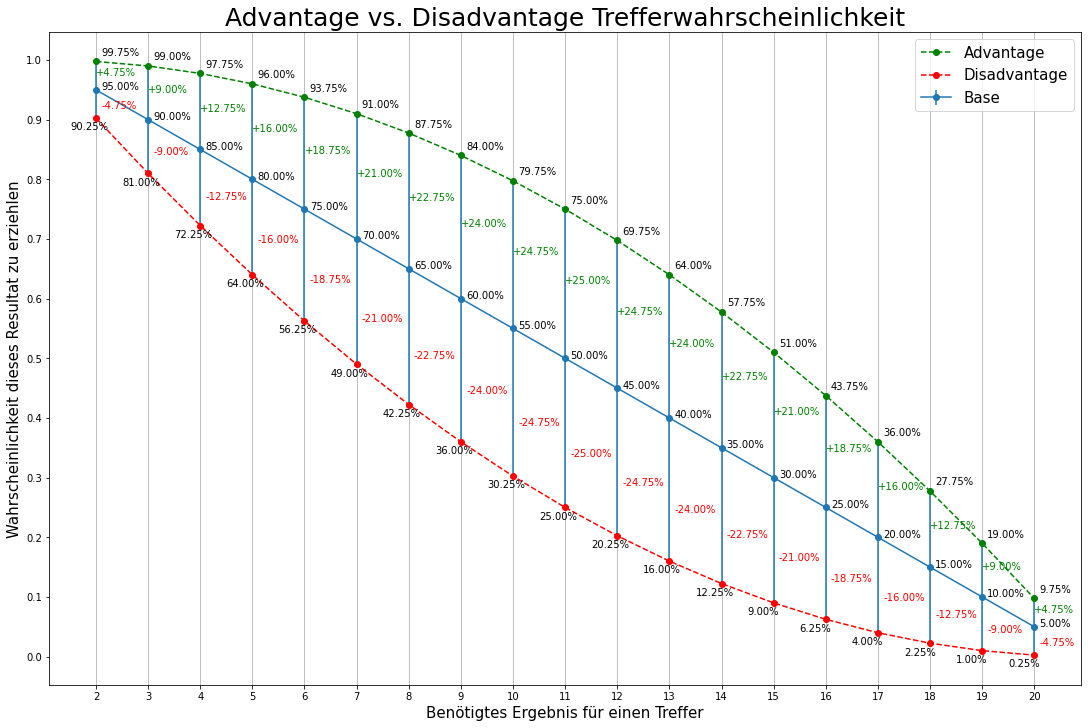

In [47]:
X = advDF.index
yerror = list(advDF["mit Advantage"]-advDF["Trefferwahrscheinlichkeit"])
fig, ax = plt.subplots(figsize=(15,10), layout="constrained")
ax.errorbar(X, y=advDF["Trefferwahrscheinlichkeit"], yerr=yerror, fmt="-o", label= "Base")
ax.plot(X, advDF["mit Advantage"], "--go", label= "Advantage")
ax.plot(X, advDF["mit Disadvantage"], "--ro", label= "Disadvantage")
for x,perc,adv,dadv,diff in zip(X, advDF["Trefferwahrscheinlichkeit"], advDF["mit Advantage"], advDF["mit Disadvantage"], advDF["Unterschied zu Base"]):
    ax.annotate(text=f"{perc:.2%}", xy=(x+0.1, perc))
    ax.annotate(text=f"{adv:.2%}", xy=(x+0.1, adv+0.01))
    ax.annotate(text=f"{dadv:.2%}", xy=(x-0.5, dadv-0.02))
    ax.annotate(text=f"{diff:+.2%}", xy=(x, perc+diff*0.5)).set_color("g")
    ax.annotate(text=f"-{diff:-.2%}", xy=(x+0.1, perc-diff*0.66)).set_color("r")
ax.grid(True, axis="x")
ax.set_xticks(ticks=X)
ax.set_yticks(ticks=np.linspace(0,1,11))
ax.set_xlabel("Benötigtes Ergebnis für einen Treffer", fontsize=TICKSIZE)
ax.set_ylabel("Wahrscheinlichkeit dieses Resultat zu erziehlen", fontsize=TICKSIZE)
ax.set_title("Advantage vs. Disadvantage Trefferwahrscheinlichkeit", fontsize=TITLESIZE)
ax.legend(loc="best", fontsize=TICKSIZE)


plt.show()